# Experimento ML 010: Otimização e Comparação de Modelos XGBoost (Versão Corrigida)

**Objetivo:** Otimizar o processo de modelagem e comparar a performance do XGBoost em duas configurações para tratar o desbalanceamento de classe:
1.  **XGBoost com `scale_pos_weight`**: Abordagem que ajusta o peso das classes diretamente no modelo.
2.  **XGBoost com SMOTE**: Abordagem que utiliza oversampling da classe minoritária antes do treinamento.

## 1. Configuração e Importações

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_auc_score)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Configurações do notebook
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 2. Carregamento e Preparação dos Dados

**ATENÇÃO:** Verifique se a variável `FILE_PATH` na célula abaixo aponta para o local correto do seu arquivo `australia_clima_v9.xlsx`.

In [2]:
# --- Constantes e Configurações ---
FILE_PATH = r'C:\Users\JacyzinGuilherme(Bip\mentoria-bip\dados_editados\australia_clima_v9.xlsx' # <-- VERIFIQUE ESTE CAMINHO!
TARGET_COL = "chove_amanha_vtr"
DATE_COL = 'data'
RANDOM_STATE = 42

# Carregando o dataset
try:
    df = pd.read_excel(FILE_PATH)
except FileNotFoundError:
    print(f"Erro: O arquivo não foi encontrado em '{FILE_PATH}'. Verifique o caminho.")

# Tratamento inicial
if 'df' in locals():
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL])
    df = df.sort_values(by=DATE_COL).reset_index(drop=True)

    print("Dados carregados e preparados.")
    print(f"Shape do dataset: {df.shape}")
    print(f"Período dos dados: de {df[DATE_COL].min().date()} a {df[DATE_COL].max().date()}")

Dados carregados e preparados.
Shape do dataset: (50159, 54)
Período dos dados: de 2007-11-01 a 2017-06-25


## 3. Divisão em Treino e Teste (Temporal)

In [3]:
# Separação de features (X) e alvo (y)
y = df[TARGET_COL].astype(int)
X = df.drop(columns=[TARGET_COL, DATE_COL])

# Divisão temporal (80% treino, 20% teste)
split_idx = int(len(df) * 0.8)

X_train = X.iloc[:split_idx].copy()
y_train = y.iloc[:split_idx].copy()
X_test = X.iloc[split_idx:].copy()
y_test = y.iloc[split_idx:].copy()

print("Shapes dos dataframes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

print("\nDistribuição do alvo no treino:")
print(y_train.value_counts(normalize=True))

print("\nDistribuição do alvo no teste:")
print(y_test.value_counts(normalize=True))

Shapes dos dataframes:
X_train: (40127, 52), y_train: (40127,)
X_test: (10032, 52), y_test: (10032,)

Distribuição do alvo no treino:
chove_amanha_vtr
0    0.786254
1    0.213746
Name: proportion, dtype: float64

Distribuição do alvo no teste:
chove_amanha_vtr
0    0.786284
1    0.213716
Name: proportion, dtype: float64


## 4. Pipeline de Pré-processamento

In [4]:
# Identificação automática das colunas
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"{len(numeric_features)} features numéricas identificadas.")
print(f"{len(categorical_features)} features categóricas identificadas.")

# Pipeline para features numéricas
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline para features categóricas
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer para aplicar os pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

40 features numéricas identificadas.
6 features categóricas identificadas.


## 5. Treinamento dos Modelos

In [5]:
# --- Modelo 1: XGBoost com scale_pos_weight ---

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculado scale_pos_weight: {scale_pos_weight:.2f}")

xgb_spw_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    n_estimators=500,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe_xgb_spw = Pipeline(steps=[("preprocess", preprocessor), ("model", xgb_spw_model)])

print("\nTreinando XGBoost com scale_pos_weight...")
pipe_xgb_spw.fit(X_train, y_train)
print("Treinamento concluído.")

Calculado scale_pos_weight: 3.68

Treinando XGBoost com scale_pos_weight...
Treinamento concluído.


In [6]:
# --- Modelo 2: XGBoost com SMOTE ---

xgb_smote_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=500,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe_xgb_smote = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(sampling_strategy=1, random_state=RANDOM_STATE, k_neighbors=10)),
    ("model", xgb_smote_model)
])

print("\nTreinando XGBoost com SMOTE...")
pipe_xgb_smote.fit(X_train, y_train)
print("Treinamento concluído.")


Treinando XGBoost com SMOTE...
Treinamento concluído.


## 6. Avaliação e Comparação de Performance

In [7]:
def evaluate_model(pipe, X_test, y_test, model_name):
    """Função para avaliar um pipeline treinado."""
    print(f"--- Avaliação do Modelo: {model_name} ---")
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred_default = (y_proba >= 0.5).astype(int)
    
    print("\n> Relatório de Classificação (Threshold = 0.5):")
    print(classification_report(y_test, y_pred_default, digits=4))
    
    cm = confusion_matrix(y_test, y_pred_default)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Não Chove', 'Chove'], yticklabels=['Não Chove', 'Chove'])
    plt.title(f'Matriz de Confusão - {model_name} (Threshold = 0.5)')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()
    
    return y_proba

def sweep_thresholds(y_true, y_proba, thresholds):
    """Gera um DataFrame de métricas para vários thresholds."""
    results = []
    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        results.append({
            'threshold': thr,
            'accuracy': accuracy_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'f1_score': f1_score(y_true, y_pred),
            'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn
        })
    return pd.DataFrame(results)

--- Avaliação do Modelo: XGBoost com scale_pos_weight ---

> Relatório de Classificação (Threshold = 0.5):
              precision    recall  f1-score   support

           0     0.9344    0.8505    0.8905      7888
           1     0.5866    0.7803    0.6697      2144

    accuracy                         0.8355     10032
   macro avg     0.7605    0.8154    0.7801     10032
weighted avg     0.8601    0.8355    0.8433     10032



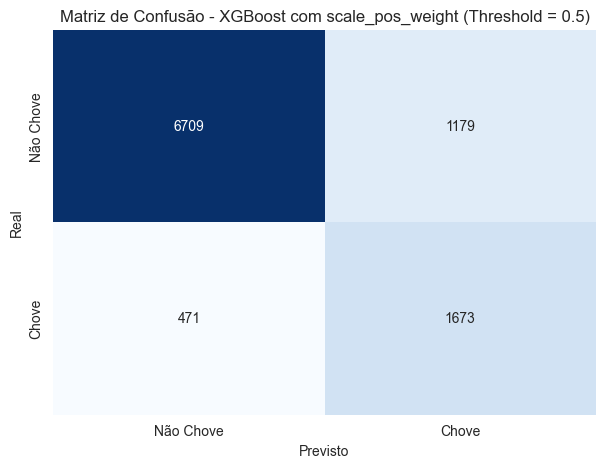

--- Avaliação do Modelo: XGBoost com SMOTE ---

> Relatório de Classificação (Threshold = 0.5):
              precision    recall  f1-score   support

           0     0.8911    0.9383    0.9141      7888
           1     0.7180    0.5784    0.6407      2144

    accuracy                         0.8613     10032
   macro avg     0.8046    0.7583    0.7774     10032
weighted avg     0.8541    0.8613    0.8557     10032



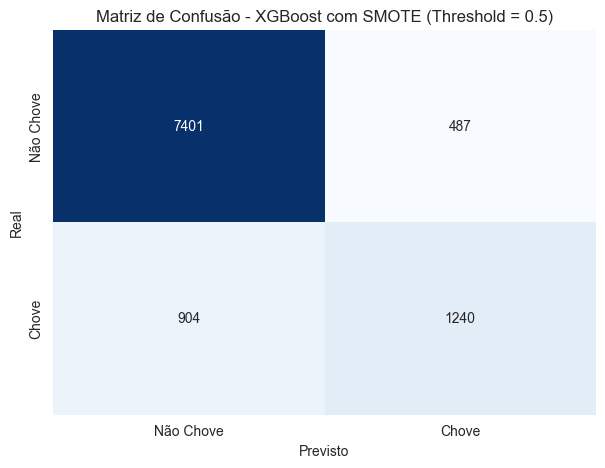

In [8]:
# Avaliar o modelo com scale_pos_weight
y_proba_spw = evaluate_model(pipe_xgb_spw, X_test, y_test, "XGBoost com scale_pos_weight")

# Avaliar o modelo com SMOTE
y_proba_smote = evaluate_model(pipe_xgb_smote, X_test, y_test, "XGBoost com SMOTE")

### 6.1. Análise de Thresholds

In [9]:
thresholds = np.arange(0.3, 0.71, 0.05)

df_thr_spw = sweep_thresholds(y_test, y_proba_spw, thresholds)
df_thr_spw['model'] = 'XGBoost (scale_pos_weight)'

df_thr_smote = sweep_thresholds(y_test, y_proba_smote, thresholds)
df_thr_smote['model'] = 'XGBoost (SMOTE)'

print(">>> Resultados para XGBoost com scale_pos_weight:")
display(df_thr_spw)

print("\n>>> Resultados para XGBoost com SMOTE:")
display(df_thr_smote)

>>> Resultados para XGBoost com scale_pos_weight:


,threshold,accuracy,recall,precision,f1_score,TP,TN,FP,FN,model
0,0.30,0.765152,0.891325,0.473723,0.618647,1911,5765,2123,233,XGBoost (scale_pos_weight)
1,0.35,0.788577,0.874534,0.503086,0.638733,1875,6036,1852,269,XGBoost (scale_pos_weight)
2,0.40,0.806719,0.846549,0.529927,0.651823,1815,6278,1610,329,XGBoost (scale_pos_weight)
3,0.45,0.823365,0.816698,0.559425,0.664012,1751,6509,1379,393,XGBoost (scale_pos_weight)
4,0.50,0.835526,0.780317,0.586606,0.669736,1673,6709,1179,471,XGBoost (scale_pos_weight)
5,0.55,0.846990,0.742071,0.618344,0.674581,1591,6906,982,553,XGBoost (scale_pos_weight)
6,0.60,0.857057,0.708022,0.652623,0.679195,1518,7080,808,626,XGBoost (scale_pos_weight)
7,0.65,0.860845,0.661847,0.678947,0.670288,1419,7217,671,725,XGBoost (scale_pos_weight)
8,0.70,0.863138,0.613340,0.707370,0.657007,1315,7344,544,829,XGBoost (scale_pos_weight)



>>> Resultados para XGBoost com SMOTE:


,threshold,accuracy,recall,precision,f1_score,TP,TN,FP,FN,model
0,0.30,0.836423,0.772388,0.589534,0.668686,1656,6735,1153,488,XGBoost (SMOTE)
1,0.35,0.848585,0.722948,0.626263,0.671141,1550,6963,925,594,XGBoost (SMOTE)
2,0.40,0.856559,0.675840,0.660739,0.668204,1449,7144,744,695,XGBoost (SMOTE)
3,0.45,0.860746,0.627799,0.692031,0.658352,1346,7289,599,798,XGBoost (SMOTE)
4,0.50,0.861344,0.578358,0.718008,0.640661,1240,7401,487,904,XGBoost (SMOTE)
5,0.55,0.862141,0.534049,0.748855,0.623469,1145,7504,384,999,XGBoost (SMOTE)
6,0.60,0.862341,0.488806,0.786197,0.602819,1048,7603,285,1096,XGBoost (SMOTE)
7,0.65,0.857656,0.433769,0.812937,0.565693,930,7674,214,1214,XGBoost (SMOTE)
8,0.70,0.854466,0.385728,0.852577,0.531150,827,7745,143,1317,XGBoost (SMOTE)


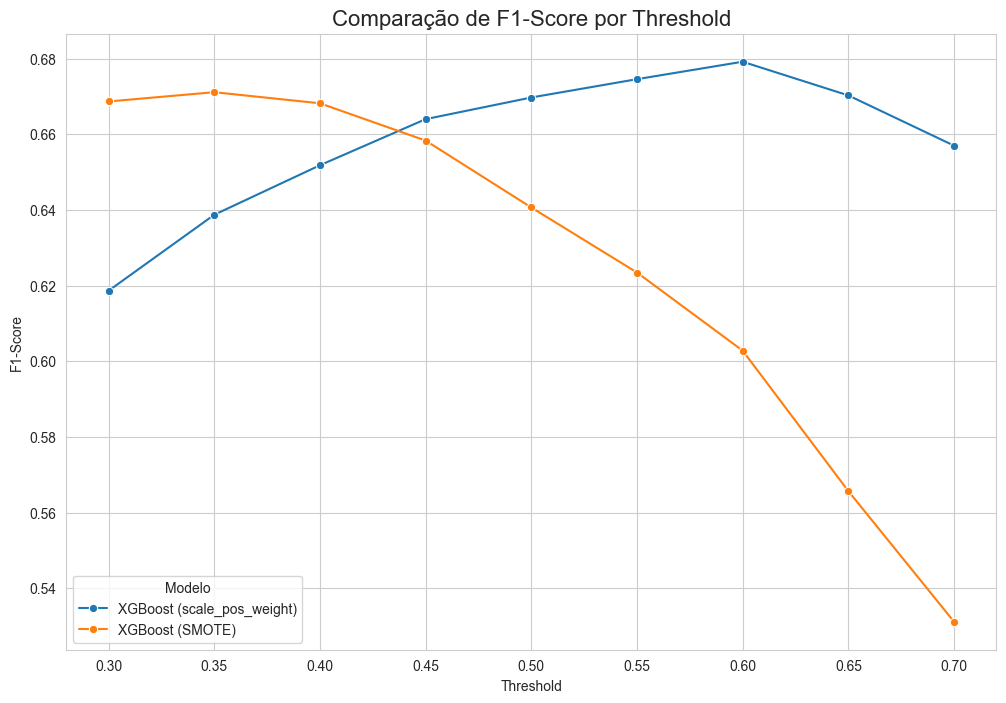

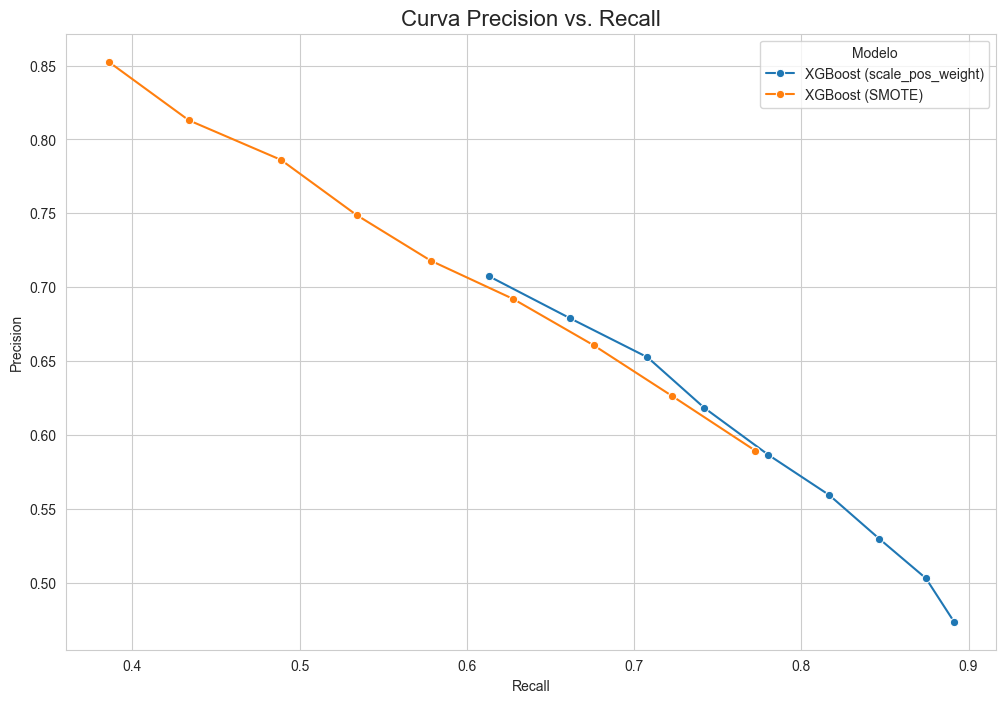

In [10]:
# Combinar os resultados para comparação
df_comparison = pd.concat([df_thr_spw, df_thr_smote])

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_comparison, x='threshold', y='f1_score', hue='model', marker='o')
plt.title('Comparação de F1-Score por Threshold', fontsize=16)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.legend(title='Modelo')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_comparison, x='recall', y='precision', hue='model', marker='o', sort=False)
plt.title('Curva Precision vs. Recall', fontsize=16)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(title='Modelo')
plt.grid(True)
plt.show()

## 7. Conclusão e Exportação

**Instruções:**
1.  Analise os gráficos e tabelas acima.
2.  Escolha o melhor modelo (`pipe_xgb_spw` ou `pipe_xgb_smote`).
3.  Escolha o melhor `threshold` com base no F1-score, recall ou precision.
4.  Atualize as variáveis `BEST_MODEL_PIPE` e `BEST_THR` na célula abaixo antes de executar.

# --- CONFIGURAR PARA EXPORTAÇÃO ---
BEST_MODEL_PIPE = pipe_xgb_smote 
BEST_MODEL_NAME = "XGBoost com SMOTE"
BEST_THR = 0.55
OUTPUT_DIR = 'output' # A pasta será criada dentro do diretório atual

# --- SCRIPT DE EXPORTAÇÃO ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

X_full = df.drop(columns=[TARGET_COL, DATE_COL])
y_proba_full = BEST_MODEL_PIPE.predict_proba(X_full)[:, 1]

df_results = pd.DataFrame({
    'data': df[DATE_COL],
    'localidade': df['localidade'],
    'chove_amanha_real': df[TARGET_COL],
    'prob_chuva': y_proba_full,
    'chove_amanha_pred': (y_proba_full >= BEST_THR).astype(int),
    'split': 'train'
})
df_results.loc[X_test.index, 'split'] = 'test'

output_filename = f'previsoes_clima_{BEST_MODEL_NAME.replace(" ", "_").lower()}_thr{str(BEST_THR).replace(".", "p")}.csv'
output_path = os.path.join(OUTPUT_DIR, output_filename)

df_results.to_csv(output_path, index=False, sep=';', decimal=',')

print(f"Resultados exportados com sucesso para:\n{output_path}")